[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Track Objects with RF-DETR and ByteTrack Tracker

ByteTrack builds on the same Kalman filter plus Hungarian algorithm framework as SORT but changes the data association strategy to use almost every detection box regardless of confidence score. It runs a two-stage matching: first match high-confidence detections to tracks, then match low-confidence detections to any unmatched tracks using IoU. This reduces missed tracks and fragmentation for occluded or weak detections while retaining simplicity and high frame rates. ByteTrack has set state-of-the-art results on standard MOT benchmarks with real-time performance, because it recovers valid low-score detections instead of discarding them.

## Setup

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Runtime` -> `Change runtime type` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Jan 28 07:44:27 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   59C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Install dependencies

You may see dependency conflict warnings in Google Colab. This is expected for the preinstalled Google Colab environment and does not affect functionality.

In [ ]:
!pip install -q inference-gpu trackers==2.1.0rc0 supervision>=0.27.0

### Download example data

Downloads example videos for testing. You can use these or replace them with your own images.

In [3]:
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-1.mp4
!wget -q https://storage.googleapis.com/com-roboflow-marketing/supervision/video-examples/bikes-1280x720-2.mp4

## Track objects

### Initiate detector and tracker

In [4]:
from inference import get_model
from trackers import ByteTrackTracker

model = get_model("rfdetr-medium")
tracker = ByteTrackTracker()

ModelDependencyMissing: Your `inference` configuration does not support SAM3 model. Install SAM3 dependencies and set CORE_MODEL_SAM3_ENABLED to True.
ModelDependencyMissing: Your `inference` configuration does not support Gaze Detection model. Use pip install 'inference[gaze]' to install missing requirements.To suppress this warning, set CORE_MODEL_GAZE_ENABLED to False.
ModelDependencyMissing: Your `inference` configuration does not support YoloWorld model. Use pip install 'inference[yolo-world]' to install missing requirements.To suppress this warning, set CORE_MODEL_YOLO_WORLD_ENABLED to False.


Resolved model_id: coco/40, dataset_id: coco, version_id: 40


### Configure annotators

In [5]:
import supervision as sv

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

box_annotator = sv.BoxAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK)

label_annotator = sv.LabelAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    text_color=sv.Color.BLACK,
    text_scale=0.8)

trace_annotator = sv.TraceAnnotator(
    color=color,
    color_lookup=sv.ColorLookup.TRACK,
    thickness=2,
    trace_length=100)

### Run detection + tracking

In [ ]:
CONFIDENCE_THRESHOLD = 0.3
NMS_THRESHOLD = 0.3

SOURCE_VIDEO_PATH = "/content/bikes-1280x720-1.mp4"
TARGET_VIDEO_PATH = "/content/bikes-1280x720-1-result.mp4"

frame_samples = []

def callback(frame, i):
    result = model.infer(frame, confidence=CONFIDENCE_THRESHOLD)[0]
    detections = sv.Detections.from_inference(result).with_nms(threshold=NMS_THRESHOLD)
    detections = tracker.update(detections)

    annotated_image = frame.copy()
    annotated_image = box_annotator.annotate(annotated_image, detections)
    annotated_image = trace_annotator.annotate(annotated_image, detections)
    annotated_image = label_annotator.annotate(annotated_image, detections, detections.tracker_id)

    if i % 30 == 0 and i != 0:
        frame_samples.append(annotated_image)

    return annotated_image

tracker.reset()

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback,
    show_progress=True,
)

### Display result

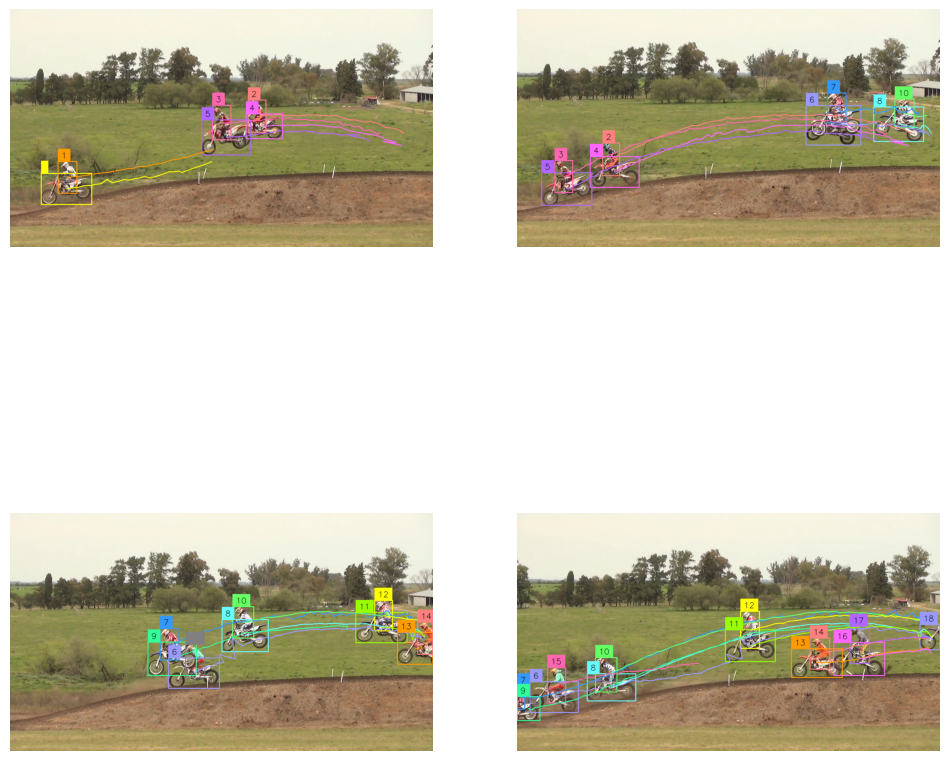

In [7]:
sv.plot_images_grid(images=frame_samples[:4], grid_size=(2, 2))

In [8]:
TARGET_VIDEO_COMPRESSED_PATH = "/content/bikes-1280x720-1-result-compressed.mp4"

!ffmpeg -y -loglevel error -i {TARGET_VIDEO_PATH} -vcodec libx264 -crf 28 {TARGET_VIDEO_COMPRESSED_PATH}

In [9]:
from IPython.display import Video

Video(TARGET_VIDEO_COMPRESSED_PATH, embed=True, width=1080)

You just combined ByteTrack tracker with RF-DETR detector. Nice work!

Trackers makes it easy to mix and match top-performing multi-object tracking algorithms with your favorite detection backends, including Inference, Ultralytics, and Transformers.

Ready to go deeper. Explore more tracking algorithms and integrations in the trackers [Documentation](https://roboflow.github.io/trackers/) or dive into the code on [GitHub](https://github.com/roboflow/trackers).

Got feedback or ideas? Open an issue on [GitHub Issues](https://github.com/roboflow/trackers/issues).